In [1]:
import util
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import pystan

# Data loading

We are still sticking with the wine quality data from UCL ML repository. It is a regression problem with 11 features.  
Using analytical solution of L2_ridge regression, we start our SGD posterior sampling and hyperparmeter optimization process. 

In [2]:
wine = [[float(j) for j in i.rstrip().split(";")] for i in open("../../ipynb/SGDasABI/winequality-white.csv").readlines()[1:]]
wine = np.array(wine)

In [3]:
# Shuffling.
index = np.arange(wine.shape[0])
np.random.shuffle(index)
wine_itr = util.dataiter(wine[index ,:-1], wine[index ,-1])

In [4]:
D = wine_itr.d
N = wine_itr.n
print D,N

11 4898


Estimating the analytically true solution.


In [5]:
X = wine_itr.X
Y = wine_itr.Y
XtX = np.linalg.inv(np.dot(np.transpose(X), X)+np.eye(wine_itr.d))
XtY = np.dot(np.transpose(X), Y)
W = np.dot(XtX, XtY)

Loading the true posterior distributions

In [6]:
truth = np.load("RWMH-posteior.npy")

# Full-covariance SGD sampling with hyperparameter optimization.

We use the full covariance method from the paper.  
Hyper-parameters are optimized via variational expected maximization.  
The exact objective function for each batch in a stochastic gradient descent is shown below.

$ [\frac{1}{S}\Sigma_{s} \frac{(y-w\cdot x)^2}{2}]+[\frac{\lambda}{2N}\Sigma_{d}w^2_{d}] + [\frac{D}{2N}log(\lambda)]$

In [7]:
def model(W, D, N):
    D = D*1.0
    N = N*1.0
    #resetting parameters
    util.reset_graph()
    
    # Input and output
    # Use Placeholder in tf for input and output.
    x_tf = tf.placeholder(tf.float64, [None, wine_itr.d])  # data matrix
    y_tf = tf.placeholder(tf.float64, [None, 1]) # target matrix
    lambda_tf = tf.Variable(1.0, name="h", dtype=tf.float64) #tf.Variable(1.0, name="h")
    learning_rate = tf.placeholder(tf.float64)
    
    # Single fully connected layer
    # Loads in the noise + optimal weights calculated above as a starting point
    W_tf = tf.Variable(W, name="w") # weight matrix
    dense = tf.matmul(x_tf, W_tf) # fully connected multiplication
    
    # Objective function. This needs to be absolutely correct.
    cost = tf.reduce_mean(tf.square(tf.subtract(y_tf, dense)))/2.0\
        +lambda_tf/2.0*tf.reduce_sum(tf.square(W_tf))/N\
        -D/2.0*tf.log(lambda_tf)/N
    
    # Optimization operations
    # SGD of learning rate 1 is used because we can manually 
    # multiply gradients with custom learning rate later.
    optimizer_sgd = tf.train.GradientDescentOptimizer(learning_rate)
    
    # Get trainable variables
    tvars = tf.trainable_variables()
    wvars = [i for i in tvars if i._variable.name[0] == "w"]
    hvars = [i for i in tvars if i._variable.name[0] == "h"]
    
    # Get gradients with respect to parameters
    w_gradients = optimizer_sgd.compute_gradients(cost, wvars)
    h_gradients = optimizer_sgd.compute_gradients(cost, hvars)

    # Learing rates holder. This is a tuple of placeholders that
    # match the size of the parameters in the variable holders.
    precision_holders = tuple(tf.placeholder(tf.float64, [np.prod([i.value for i in g[0].shape]),\
                        np.prod([i.value for i in g[0].shape])]) for g in w_gradients)
    
    # Calculating a sgd step given prescition matrix.
    sgd_steps = [(tf.matmul(precision_holders[i], w_gradients[i][0]),\
                           w_gradients[i][1]) for i in range(len(w_gradients))]
    
    # Applying it to current weights.
    train_w = optimizer_sgd.apply_gradients(sgd_steps)
    train_h = optimizer_sgd.apply_gradients(h_gradients)
    
    return dict(
        x = x_tf,
        y = y_tf,
        _lambda = lambda_tf,
        lr = learning_rate,
        w_gradients = w_gradients,
        h_gradients = h_gradients,
        train_w = train_w,
        train_h = train_h,
        current_w = W_tf,
        precision_matrix = precision_holders
    )

In [8]:
def SGD_sampling(m):
    # defining necessary parameters
    sample_num = 30001
    burnin = 1000
    batch_size = 100
    lr = 0.01
    decay = 0.9999

    init = tf.global_variables_initializer()
    with tf.Session() as sess:
        sess.run(init)

        epsilons = []
        samples =[]
        lambdas = []

        # C keeps track of current gradient covariance.
        C = np.zeros((11,11))
        for s in range(sample_num):
            if (len(samples)+1)%5000 == 0:
                print "Collected", len(samples)+1, "samples"

            # get a batch of samples
            xb, yb = wine_itr.next(batch_size)

            # get the batch wise stochastic gradient
            gb = sess.run(m["w_gradients"], feed_dict={m["x"]: xb, m["y"]: yb, m["lr"]:1.0})
            g1 = sess.run(m["w_gradients"], feed_dict={m["x"]: xb[0:1,], m["y"]: yb[0:1,], m["lr"]:1.0})

            # calculating the learning rate
            temp = np.dot(g1[0][0]-gb[0][0], np.transpose(g1[0][0]-gb[0][0]))
            k = 1.0/(s+1)
            C = (1-k)*C + k*temp
            epsilon = 2.0*batch_size/N*np.linalg.inv(C)
            epsilons.append(epsilon)

            # get cost and gradients and weights
            if s > burnin:
                w, _ = sess.run([m["current_w"], m["train_w"]], \
                                 feed_dict={m["x"]: xb, m["y"]: yb, m["precision_matrix"]:[epsilon], m["lr"]:1.0})
                lr = lr*decay
                _, gh = sess.run([m["train_h"], m["h_gradients"]], feed_dict={m["x"]: xb, m["y"]: yb, m["lr"]:lr})            
                lambdas.append(sess.run(m["_lambda"]))                     
                samples.append(w[:,0])

    samples = np.array(samples)
    print lr
    return samples, lambdas

# Running the experiments.

Building the model and sampling

In [9]:
m = model(W, D, N)

In [10]:
samples, lambdas = SGD_sampling(m)

Collected 5000 samples
Collected 10000 samples
Collected 15000 samples
Collected 20000 samples
Collected 25000 samples
0.000550152417361


Here we compare weights with optimal hyperparmeters and weights with lambda = 1.0

You can see that the hyperparameter stabilizes around 0.03 with SGD stepsize decay of 0.99 per time step.

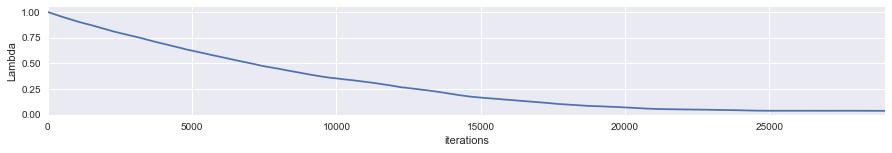

Last value 0.03683350986


In [43]:
plt.figure(figsize=(15,2))
plt.plot(lambdas)
plt.xlim(0,len(lambdas))
plt.ylabel("Lambda")
plt.xlabel("iterations")
plt.show()
print "Last value", lambdas[-1]

# Optimization with STAN

In [136]:
model_code = """
data {
  int n;                                
  int m;
  matrix[n, m] A;
  vector[n] y;
}
parameters {
  vector[m] delta;
  real<lower=0> lambda;
}
model {
  lambda ~ exponential(0.01);
  for (i in 1:m) {
    delta[i] ~ normal(0, lambda);
  }
  y ~ normal(A * delta, 1);
}
"""

In [137]:
data = {
    "n": wine_itr.X.shape[0],
    "m": wine_itr.d,
    "A": wine_itr.X,
    "y": wine_itr.Y[:,0]
}

In [138]:
fit = pystan.stan(model_code=model_code, data=data, iter=1500, warmup=500, chains=1)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_e1d4b361529b1feb86f37bdc01786447 NOW.


In [139]:
fit

Inference for Stan model: anon_model_e1d4b361529b1feb86f37bdc01786447.
1 chains, each with iter=1500; warmup=500; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=1000.

            mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
delta[0]    1.33    0.01   0.27    0.8   1.14   1.34   1.52   1.85  476.0    1.0
delta[1]   -1.17  5.7e-3   0.15  -1.48  -1.27  -1.17  -1.07  -0.87  737.0    1.0
delta[2]    1.07  7.2e-3    0.2   0.67   0.94   1.07   1.21   1.44  774.0    1.0
delta[3]   -3.26    0.03   0.59  -4.48  -3.64  -3.25  -2.87  -2.04  428.0    1.0
delta[4]    1.79  8.1e-3   0.24    1.3   1.64   1.79   1.94   2.25  853.0    1.0
delta[5]    3.09    0.01   0.33   2.48   2.87   3.09   3.32   3.73  711.0    1.0
delta[6]    0.32  7.9e-3   0.21   -0.1   0.19   0.32   0.46   0.74  692.0    1.0
delta[7]   14.48    0.06   1.11  12.26  13.72  14.48  15.19  16.82  391.0    1.0
delta[8]     1.5  6.3e-3   0.14   1.22   1.41   1.51    1.6   1.79  526.0    1.0
de

In [129]:
stan_samples = fit.extract()["delta"]

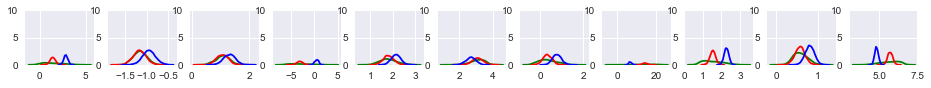

Green: SGD
Red: STAN
Blue: RMWH without regularization


In [135]:
util.plot_posterior([samples, stan_samples, truth], ["green", "red", "blue"])
print "Green: SGD"
print "Red: STAN"
print "Blue: RMWH without regularization"

Lambda of 0.03 is 0.03/2 = 0.015 

# Finding the right hyperparameter with cross-validation

Again, the objective function is  
$ [\frac{1}{2S}\Sigma_{s} \frac{(y-w\cdot x)^2}{2}]+[\frac{\lambda}{2N}\Sigma_{d}w^2_{d}] - [\frac{D}{2N}log(\lambda)]$

We treat lambda as a constant so we can drop the last term.
For the whole data set our objective is..  
$ [\frac{1}{2N}\Sigma_{n} \frac{(y-w\cdot x)^2}{2}]+[\frac{\lambda}{2N}\Sigma_{d}w^2_{d}]$  

Again, the closed form solution is here.  
$L = (Y−X\beta)^T(Y−X\beta)+\lambda\beta^T\beta$  
$W_{opt}=(X^TX+\lambda I)^{-1}X^TY$

In [46]:
def getW(X, Y, _lambda):
    XtX = np.linalg.inv(np.dot(np.transpose(X), X)+_lambda*np.eye(wine_itr.d))
    XtY = np.dot(np.transpose(X), Y)
    W = np.dot(XtX, XtY)
    return W

In [47]:
def testW(X, Y, W):
    return np.mean(np.square(Y - np.dot(X,W)))

In [48]:
def get_splits(data, num_batch, batch):
    index = data[0].shape[0]/num_batch
    ret = []
    for d in data:
        train = []
        for i in range(num_batch):
            if batch == i:
                valid = d[index*i:index*(i+1)]
            else:
                train.append(d[index*i:index*(i+1)])
        ret.append([np.concatenate(train, axis=0), valid])
    return ret

In [49]:
MSEs = []
regularizer = [1.1**(-1*i) for i in range(-10, 80)]
for l in regularizer:
    total_mse = []
    for i in range(5):
        (xb, xbv), (yb, ybv) = get_splits((X,Y), 5, i)
        W = getW(xb, yb, l)
        mse = testW(xbv, ybv, W)
        total_mse.append(mse)
    MSEs.append(np.mean(total_mse))

There must be something off about my implementation....

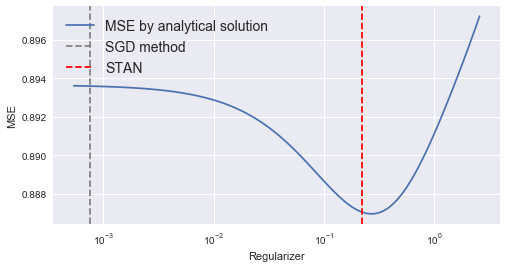

In [51]:
plt.figure(figsize=(8,4))
plt.plot(regularizer, MSEs, label="MSE by analytical solution")
plt.xscale("log")
plt.axvline(0.03/40, c="gray", ls="--", label="SGD method")
plt.axvline(0.22, c="red", ls="--", label="STAN")
plt.xlabel("Regularizer")
plt.ylabel("MSE")
plt.legend(fontsize=14)
plt.show()